In [1]:
# Importando pacotes necessários
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

from scipy.stats import spearmanr

from collections import Counter

In [2]:
# Função para criar o modelo de rede neural
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(12, activation='relu', input_shape=(input_shape,)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Aplicando a seleção de Dados por k-fold

In [3]:
# Carregar o arquivo 'dados.csv' no dataframe
df_kfold = pd.read_csv('df_pca.csv')

In [4]:
# Separando as variáveis objetivo
X = df_kfold.drop('CLASSE', axis=1)
y = df_kfold['CLASSE']

In [5]:
#Definindo o número de folds

num_folds = 7
sub_num_folds = 7

In [6]:
#Configurar o k-Fold Principal

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [7]:
#Dividir os Dados para o k-fold teste

fold_indices = list(kf.split(X, y))

In [8]:
# Iterar sobre cada fold principal
for fold, (train_index, test_index) in enumerate(fold_indices):
    # Dados de treino e teste para o fold principal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Aplicar o sub-k-fold para treino e validação
    sub_kf = StratifiedKFold(n_splits=sub_num_folds, shuffle=True, random_state=42)

    # Armazenar os índices dos folds secundários
    sub_fold_indices = list(sub_kf.split(X_train, y_train))

    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_fold_indices):
        # Dados de treino e validação para o sub-k-fold
        X_sub_train, X_sub_val = X_train.iloc[sub_train_index], X_train.iloc[sub_val_index]
        y_sub_train, y_sub_val = y_train.iloc[sub_train_index], y_train.iloc[sub_val_index]

        # Aqui você pode treinar e validar seu modelo
        # Exemplo: print(f'Fold {fold + 1}, Sub-Fold {sub_fold + 1}')


Testando disposição das Classes

In [9]:
# from collections import Counter
# import pandas as pd

# # Exemplo de dataframe com rótulos (alvo)
# y = pd.Series(y)  # Supondo que seus rótulos estejam em um array ou lista chamada 'y'

# # Inicializar o StratifiedKFold
# kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# # Iterar pelos folds principais
# for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Contagem das classes no treino e teste
#     train_counts = Counter(y_train)
#     test_counts = Counter(y_test)
    
#     # print(f"Fold {fold + 1}")
#     # print(f"Distribuição no treino: {train_counts}")
#     # print(f"Distribuição no teste: {test_counts}\n")


In [ ]:
# Aqui é só pra contar e ver a proporção dos Folds e Subfolds

# Suponha que X seja um DataFrame e y seja uma Series
# Se X é um DataFrame e y é uma Series
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Iterar pelos folds principais
for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Contagem das classes no treino e teste
    train_counts = Counter(y_train)
    test_counts = Counter(y_test)
    
    print(f"Fold {fold + 1}")
    print(f"Distribuição no treino: {train_counts}")
    print(f"Distribuição no teste: {test_counts}\n")

    # Subdividir o treino em subfolds
    sub_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    
    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_kfold.split(X_train, y_train)):
        y_sub_train = y_train.iloc[sub_train_index]
        y_sub_val = y_train.iloc[sub_val_index]
        
        # Contagem das classes nos subfolds
        sub_train_counts = Counter(y_sub_train)
        sub_val_counts = Counter(y_sub_val)
        
        print(f"  Subfold {sub_fold + 1}")
        print(f"  Distribuição no treino: {sub_train_counts}")
        print(f"  Distribuição na validação: {sub_val_counts}\n")



Aplicando as redes neurais no k-fold do PCA

In [9]:
# Lista para armazenar as métricas de avaliação
validation_reports = []

In [10]:
best_model_path = "best_model.keras"  # Local para salvar o melhor modelo

# Configurar o callback para salvar o melhor modelo com base na métrica de validação
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Variável para armazenar o melhor desempenho
best_val_accuracy = 0
best_fold = None

In [11]:
# Inicializar uma lista para armazenar a precisão ponderada de cada fold
fold_accuracies = []

In [12]:
# Exibir precisões ponderadas de cada fold
for accuracy in fold_accuracies:
    print(f"Fold {accuracy['fold']}, Sub-Fold {accuracy['sub_fold']}: Acurácia de Teste = {accuracy['test_accuracy']:.4f}")

In [13]:
# Codificar os rótulos para garantir que estejam no intervalo esperado
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [14]:
# Armazenar as precisões por classe para cada sub-fold
sub_fold_precisions = []

# Exibir a precisão de cada classe
for fold, (train_index, test_index) in enumerate(fold_indices):
    # Dados de treino e teste para o fold principal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Aplicar Sub-K-Fold para treino e validação
    sub_fold_indices = list(sub_kf.split(X_train, y_train))
    
    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_fold_indices):
        # Dados de treino e validação para o sub-k-fold
        X_sub_train, X_sub_val = X_train.iloc[sub_train_index], X_train.iloc[sub_val_index]
        y_sub_train, y_sub_val = y_train[sub_train_index], y_train[sub_val_index]
        
        # Criar o modelo
        num_classes = len(label_encoder.classes_)
        model = create_model(X.shape[1], num_classes)
        
        # Treinar o modelo e salvar o histórico
        history = model.fit(
            X_sub_train, y_sub_train, 
            epochs=100, batch_size=32, 
            verbose=0, validation_data=(X_sub_val, y_sub_val),
            callbacks=[checkpoint]
        )

        # Avaliar no conjunto de teste
        y_test_pred = model.predict(X_test)
        y_test_pred_classes = np.argmax(y_test_pred, axis=1)

        # Calcular acurácia de teste
        test_accuracy = np.mean(y_test_pred_classes == y_test)

        # Atualizar o melhor modelo se este fold for melhor
        if test_accuracy > best_val_accuracy:
            best_val_accuracy = test_accuracy
            best_fold = (fold, sub_fold)
        
        # Calcular a matriz de confusão
        cm = confusion_matrix(y_test, y_test_pred_classes, labels=np.arange(num_classes))
        
        # Calcular a precisão de cada classe
        class_precisions = precision_score(y_test, y_test_pred_classes, average=None)
        
        # Armazenar a precisão de cada classe para o sub-fold
        sub_fold_precisions.append({
            'fold': fold,
            'sub_fold': sub_fold,
            'precisions': class_precisions
        })

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D842481B20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [15]:
# Exibir precisões de cada classe para cada sub-fold
for sub_fold_precision in sub_fold_precisions:
    print(f"Fold {sub_fold_precision['fold']}, Sub-Fold {sub_fold_precision['sub_fold']}:")
    for i, precision in enumerate(sub_fold_precision['precisions']):
        print(f"  Precisão da Classe {i}: {precision:.4f}")

Fold 0, Sub-Fold 0:
  Precisão da Classe 0: 0.2000
  Precisão da Classe 1: 0.6250
  Precisão da Classe 2: 0.4500
  Precisão da Classe 3: 0.4222
  Precisão da Classe 4: 0.5897
  Precisão da Classe 5: 0.7000
Fold 0, Sub-Fold 1:
  Precisão da Classe 0: 0.2500
  Precisão da Classe 1: 0.1667
  Precisão da Classe 2: 0.4750
  Precisão da Classe 3: 0.4681
  Precisão da Classe 4: 0.6250
  Precisão da Classe 5: 0.8000
Fold 0, Sub-Fold 2:
  Precisão da Classe 0: 0.2500
  Precisão da Classe 1: 0.5714
  Precisão da Classe 2: 0.3684
  Precisão da Classe 3: 0.4130
  Precisão da Classe 4: 0.5897
  Precisão da Classe 5: 0.6522
Fold 0, Sub-Fold 3:
  Precisão da Classe 0: 0.3333
  Precisão da Classe 1: 0.5714
  Precisão da Classe 2: 0.5484
  Precisão da Classe 3: 0.4717
  Precisão da Classe 4: 0.6216
  Precisão da Classe 5: 0.7391
Fold 0, Sub-Fold 4:
  Precisão da Classe 0: 0.2000
  Precisão da Classe 1: 0.7143
  Precisão da Classe 2: 0.5000
  Precisão da Classe 3: 0.4694
  Precisão da Classe 4: 0.6053
 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Melhor acurácia no fold 6, sub-fold 2: 0.5961538461538461


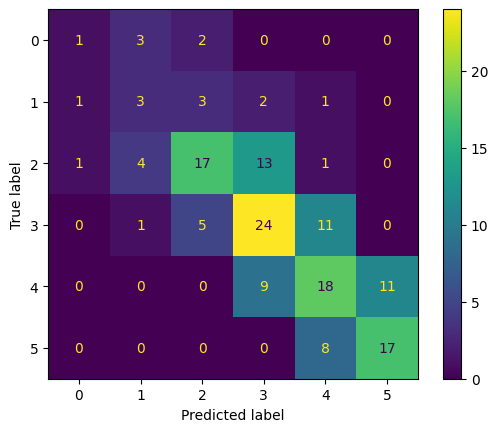

In [16]:
# Carregar o melhor modelo
best_model = load_model(best_model_path)

# Fazer previsões no conjunto de teste final
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Exibir a acurácia final do melhor modelo
print(f"Melhor acurácia no fold {best_fold[0]+1}, sub-fold {best_fold[1]+1}: {best_val_accuracy}")

In [17]:
# Calcular a matriz de confusão original
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

# Frequência das classes no conjunto de dados
class_counts = np.bincount(y_test)  # Conta o número de ocorrências de cada classe
class_weights = 1.0 / class_counts  # Calcula o peso de cada classe

# Matriz de confusão ponderada
weighted_conf_matrix = conf_matrix * class_weights[:, np.newaxis]

# Exibir a matriz de confusão ponderada
print("Matriz de Confusão Ponderada:")
print(weighted_conf_matrix)

# Calcular a precisão de cada classe
precisions = []
for i in range(weighted_conf_matrix.shape[0]):
    true_positives = weighted_conf_matrix[i, i]  # Verdadeiros Positivos
    false_positives = sum(weighted_conf_matrix[:, i]) - true_positives  # Falsos Positivos
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    precisions.append(precision)

# Exibir a precisão de cada classe
for idx, precision in enumerate(precisions):
    print(f'Precisão da Classe {idx}: {precision:.4f}')


Matriz de Confusão Ponderada:
[[0.16666667 0.5        0.33333333 0.         0.         0.        ]
 [0.1        0.3        0.3        0.2        0.1        0.        ]
 [0.02777778 0.11111111 0.47222222 0.36111111 0.02777778 0.        ]
 [0.         0.02439024 0.12195122 0.58536585 0.26829268 0.        ]
 [0.         0.         0.         0.23684211 0.47368421 0.28947368]
 [0.         0.         0.         0.         0.32       0.68      ]]
Precisão da Classe 0: 0.5660
Precisão da Classe 1: 0.3207
Precisão da Classe 2: 0.3847
Precisão da Classe 3: 0.4232
Precisão da Classe 4: 0.3981
Precisão da Classe 5: 0.7014


In [20]:
# # Exibir precisões de cada classe para cada sub-fold
# for sub_fold_precision in sub_fold_precisions:
#     print(f"Fold {sub_fold_precision['fold']}, Sub-Fold {sub_fold_precision['sub_fold']}:")
#     for i, precision in enumerate(sub_fold_precision['precisions']):
#         print(f"  Precisão da Classe {i}: {precision:.4f}")

Guardando a precisão de cada classe

In [18]:
precisao_classe_A = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_A.append(sub_fold_precisions[i]['precisions'][0])

precisao_classe_B1 = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_B1.append(sub_fold_precisions[i]['precisions'][1])

precisao_classe_B2 = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_B2.append(sub_fold_precisions[i]['precisions'][2])

precisao_classe_C1 = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_C1.append(sub_fold_precisions[i]['precisions'][3])

precisao_classe_C2 = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_C2.append(sub_fold_precisions[i]['precisions'][4])

precisao_classe_DE = []
for i in range(len(sub_fold_precisions)):
    precisao_classe_DE.append(sub_fold_precisions[i]['precisions'][5])


In [ ]:
import statistics

precisao_media_DE = statistics.mean(precisao_classe_C2)
print(precisao_media_DE)

In [30]:
# #Histograma de precisão
# nbinsA = int(np.sqrt(len(precisao_classe_A)))
# plt.hist(precisao_classe_A, bins = nbinsA, edgecolor='black') 

In [19]:
# Inicializar uma lista de listas para armazenar as precisões de cada classe
precisoes_classes = [[] for _ in range(6)]

# Preencher as listas com as precisões obtidas em cada sub-kfold
for i in range(len(sub_fold_precisions)):
    for classe in range(6):
        precisoes_classes[classe].append(sub_fold_precisions[i]['precisions'][classe])

# Calcular a média de precisão de cada classe
media_precisoes_classes = [sum(precisoes)/len(precisoes) for precisoes in precisoes_classes]

# Exibir as médias de precisão de cada classe
for classe, media in enumerate(media_precisoes_classes):
    print(f"Classe {classe+1}: Média de Precisão = {media:.4f}")


Classe 1: Média de Precisão = 0.3124
Classe 2: Média de Precisão = 0.2898
Classe 3: Média de Precisão = 0.4717
Classe 4: Média de Precisão = 0.4471
Classe 5: Média de Precisão = 0.5704
Classe 6: Média de Precisão = 0.7024
